# WIKI-SHEAF

@ Alessio Borgi
@ Stefano Previti

### 0: IMPORTING LIBRARIES

In [3]:
!pip install requests datasets networkx matplotlib torch torch-geometric sentence-transformers

In [4]:
### LIBRARIES NECESSARY FROM STEP 0 ON ###
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# Only necessary if you take the dataset from the drive instead from HuggingFace.
from google.colab import drive
drive.mount('/content/drive')

### LIBRARIES NECESSARY FROM STEP 1 ON ###
import networkx as nx

### LIBRARIES NECESSARY FROM STEP 2 ON ###
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_networkx
from sentence_transformers import SentenceTransformer



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0.5: TRAINING SET LOADING, INSPECTION & DISCOVERY

We make some exploration from the dataset. In the first version of the data provided, we noticed the following "issues". The first and second problems have been solved with the introduction of the new dataset version, while the third and fourth (actually not being problems, but dataset features), still persist.

**NaN LABEL PRESENCE**

As first thing we noticed that there are 7 rows that are all missing the "label" value.
- We decide to eliminate directly these lines since they are both not useful if they are not providing a label and are only very few outliers (7/6251), due to maybe errors in the labeling step.

**LABEL INCONSISTENCIES**

The list of the labels are not actually really containig only 3 labels. Indeed, by making a set operation over the "labels" column, we noticed that it contains: *{'cultural exclusive', 'cultural', 'cultural agnostic', 'cult', 'cultural representative', 'cultural agn', 'cultural represent', 'cultural ex', 'cultural ag'}*.
  - We decided to counteract this issue by **mantaining only the 3 labels** *{'cultural exclusive', 'cultural representative', 'cultural agnostic'}*.
  - For the lines whose labels are *{'cultural agn', 'cultural ag'}*, the labels are sobstituted with "cultural agnostic".
  - For the lines whose labels are *{'cultural represent'}*, the labels are sobstituted with *{'cultural representative'}*.
  - For the lines whose labels are *{'cultural ex'}*, the labels are sobstituted with *{'cultural exclusive'}*.
  - For the lines whose labels are *{'cultural', 'nan', 'cult'}*, we decided to directly drop them.

(Notice that these labels inconsistencies are really outliers. Indeed, we will remain with out dataset being **6238 samples** long).

**CLASS IMBALANCE**

After this cleaning, we notice that the samples we have at our disposal is not provided in an equal manner, but we have instead a **Class Imbalance** issue, Due to the fact that this is not so imbalanced, we decide to just take this into account at **Training Time**, in the future model, by using a **Class Weighting** in the **Loss Function** (e.g., *Weighted Cross-Entropy*).

**NAME DUPLICATES**

We also notice that the dataset contains duplicates in the "name" column, meaning that there are some words that have a different meaning depending on the context. Since these are very few, we decide to mantain them and not to delete them (also because would be wrong to do this).



##### 0.5.0: UTILS FUNCTIONS

In [5]:
def check_nan_labels(df):
    ''' Util function to check nan label presence. '''

    # 1) Count missing values per column and print them out.
    print("=== NaN LABEL PRESENCE ===")
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()
    print(f"Total missing values in the DataFrame: {total_missing}\n")
    print("Missing values by column:")
    print(missing_counts)
    print("\nRows with missing values and the respective columns:")
    for idx, row in df.iterrows():
        missing_cols = row[row.isnull()].index.tolist()
        if missing_cols:
            print(f"Row {idx}: {missing_cols}")

    # 2) SOLUTION ADOPTED: Drop the rows containing NaN.
    print("DataFrame shape before dropping rows with NaN:", df.shape)
    df = df.dropna()
    print("DataFrame shape after dropping rows with NaN:", df.shape)
    print("====== END =====\n")
    return df

In [6]:
def check_labels_inconsistencies(df):
    ''' Utils function to check whether the labels present inconsistencies. '''

    print("=== LABEL INCONSISTENCIES PRESENCE ===")
    # 1) Label Inconsistencies discovery.
    print("Original unique labels:")
    print(set(df["label"].dropna().unique()))

    # Make a copy of the DataFrame to avoid SettingWithCopyWarning.
    df_clean = df.copy()

    # 2) Define the mapping for substitutions and replace labels.
    mapping = {
        "cultural agn": "cultural agnostic",
        "cultural ag": "cultural agnostic",
        "cultural represent": "cultural representative",
        "cultural ex": "cultural exclusive"
    }

    df_clean.loc[:, "label"] = df_clean["label"].replace(mapping)

    # 3) Drop the ambiguous rows.
    drop_set = {"cultural", "cult"}
    print("DataFrame shape before dropping rows with ambiguous labels:", df_clean.shape)
    df_clean = df_clean[~df_clean["label"].isin(drop_set)]
    print("DataFrame shape after dropping rows with ambiguous labels:", df_clean.shape)

    valid_labels = {"cultural exclusive", "cultural representative", "cultural agnostic"}
    df_clean = df_clean[df_clean["label"].isin(valid_labels)]

    print("\nUnique labels after cleaning:")
    print(set(df_clean["label"].unique()))
    df = df_clean.copy()
    print("====== END =====\n")
    return df

In [7]:
def visualize_class_imbalance(df):
    ''' Utils function to visualize the Class Imbalance Distribution with a Histogram. '''
    # 1) Count the occurrences of each label.
    label_counts = df["label"].value_counts()
    print("\nLabel Counts:")
    print(label_counts)

    # 2) Visualize the label distribution.
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in the Dataset (After Cleaning)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
def check_duplicates(df):
    ''' Utils function to check for duplicates. '''
    # Check for duplicates in the "name" column.
    duplicate_mask = df["name"].duplicated(keep=False)
    duplicates = df.loc[duplicate_mask, "name"].unique()
    print("Cells that are not unique in column 'name':")
    print(duplicates)

#### 0.5: OLD-VERSION (DATASET)

##### 0.5.0: SETUP STEP

In [7]:
### SETUP STEP ###

# ADJUST VALUES ACCORDING TO YOUR CASE #

# Adjust the path to the training dataset(file) according to your directory structure.
file_path = '/content/drive/MyDrive/MNLP/HW1/[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv'


In [8]:
# 1) Load the TSV file into a Pandas DataFrame.
df = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')
df.head()


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative


##### 0.5.1: NaN LABEL PRESENCE

In [9]:
df = check_nan_labels(df)

=== NaN LABEL PRESENCE ===
Total missing values in the DataFrame: 7

Missing values by column:
item           0
name           0
description    0
type           0
category       0
subcategory    0
label          7
dtype: int64

Rows with missing values and the respective columns:
Row 1214: ['label']
Row 1651: ['label']
Row 2831: ['label']
Row 3236: ['label']
Row 4853: ['label']
Row 5885: ['label']
Row 6063: ['label']
DataFrame shape before dropping rows with NaN: (6251, 7)
DataFrame shape after dropping rows with NaN: (6244, 7)
====== END =====



##### 0.5.2: LABEL INCONSISTENCIES

In [10]:
df = check_labels_inconsistencies(df)


=== LABEL INCONSISTENCIES PRESENCE ===
Original unique labels:
{'cultural ag', 'cultural', 'cultural agn', 'cultural ex', 'cultural represent', 'cultural exclusive', 'cultural agnostic', 'cultural representative', 'cult'}
DataFrame shape before dropping rows with ambiguous labels: (6244, 7)
DataFrame shape after dropping rows with ambiguous labels: (6238, 7)

Unique labels after cleaning:
{'cultural agnostic', 'cultural representative', 'cultural exclusive'}
====== END =====



##### 0.5.3: CLASS IMBALANCE


Label Counts:
label
cultural exclusive         2686
cultural agnostic          1866
cultural representative    1686
Name: count, dtype: int64


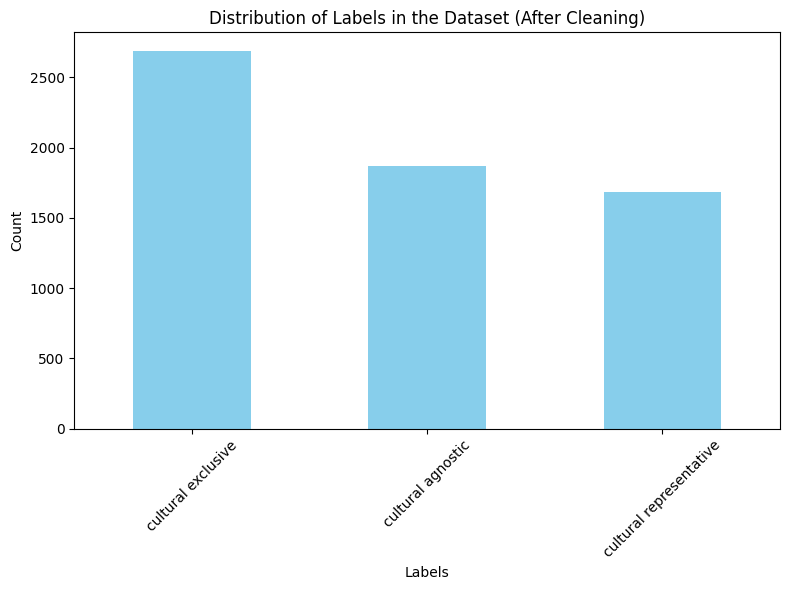

In [11]:
visualize_class_imbalance(df)

##### 0.5.4: DUPLICATES DISCOVERY

In [12]:
check_duplicates(df)

Cells that are not unique in column 'name':
['prefect' 'Pirate Party' 'Socialist Party' 'central government'
 'Breithorn' 'Alexandria']


##### 0.5.5: CLEANED DATASET INFORMATION


In [13]:
# 1) Display basic DF information.
print("=== DataFrame Info ===")
df.info()



=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 6238 entries, 0 to 6250
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item         6238 non-null   object
 1   name         6238 non-null   object
 2   description  6238 non-null   object
 3   type         6238 non-null   object
 4   category     6238 non-null   object
 5   subcategory  6238 non-null   object
 6   label        6238 non-null   object
dtypes: object(7)
memory usage: 389.9+ KB


In [14]:
# 2) Display DF Staistics.
print("\n=== DataFrame Statistics===")
print(df.describe())


=== DataFrame Statistics===
                                         item                name description  \
count                                    6238                6238        6238   
unique                                   6238                6232        5659   
top     http://www.wikidata.org/entity/Q67094  central government  film genre   
freq                                        1                   2          32   

          type  category subcategory               label  
count     6238      6238        6238                6238  
unique       2        19         108                   3  
top     entity  politics  politician  cultural exclusive  
freq      3919       532          99                2686  


In [15]:
# 3) Check for duplicate rows
duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicate_mask])

# (DUPLICATES NOT PRESENT) !

Number of duplicate rows: 0


In [16]:
# 4) Checking that we have really 19 categories, and also checking the according subcategories.
unique_categories = df["category"].unique()
unique_subcategories = df["subcategory"].unique()

print("Unique Categories:")
print(unique_categories)
print(len(unique_categories))
print("\nUnique Subcategories:")
print(unique_subcategories)
print(len(unique_subcategories))



Unique Categories:
['politics' 'food' 'architecture' 'transportation' 'sports' 'media'
 'philosophy and religion' 'literature' 'visual arts' 'fashion'
 'comics and anime' 'performing arts' 'music' 'films' 'books' 'history'
 'gestures and habits' 'biology' 'geography']
19

Unique Subcategories:
['politician' 'political party' 'government agency' 'law' 'policy'
 'government' 'food' 'drink' 'dish' 'ingredient' 'cook'
 'cooking technique' 'architectural structure' 'architectural style'
 'architect' 'construction' 'building' 'building material'
 'transport company' 'automobile manufacturer' 'transport'
 'mode of transport' 'station' 'athlete' 'sports team' 'sport'
 'sports club' 'recurring sporting event' 'sports equipment'
 'media company' 'magazine' 'television' 'production company'
 'film studio' 'streaming service' 'philosopher' 'religious leader'
 'religion' 'philosophy' 'philosophical movement' 'religious movement'
 'poetry' 'poet' 'writing style' 'literary genre' 'literary award'
 'w

In [17]:
# 5) Category-SubCategories Dictionary construction.
cat_subcat_dict = df.groupby("category")["subcategory"].unique().to_dict()

print("Categories and their subcategories:")
for cat, subcats in cat_subcat_dict.items():
    print(f"Category: {cat} -> Subcategories: {list(subcats)} (Count: {len(subcats)})")

Categories and their subcategories:
Category: architecture -> Subcategories: ['architectural structure', 'architectural style', 'architect', 'construction', 'building', 'building material'] (Count: 6)
Category: biology -> Subcategories: ['organism', 'biologist', 'animal', 'tree', 'plant', 'fish'] (Count: 6)
Category: books -> Subcategories: ['book', 'bookstore', 'non-fiction writer'] (Count: 3)
Category: comics and anime -> Subcategories: ['comics', 'comics artist', 'manga', 'animated film', 'animation technique', 'animation studio'] (Count: 6)
Category: fashion -> Subcategories: ['clothing', 'traditional costume', 'designer', 'fashion trend', 'textile', 'model'] (Count: 6)
Category: films -> Subcategories: ['film', 'film festival', 'film director', 'film producer', 'film genre'] (Count: 5)
Category: food -> Subcategories: ['food', 'drink', 'dish', 'ingredient', 'cook', 'cooking technique'] (Count: 6)
Category: geography -> Subcategories: ['geographic location', 'environment', 'mountai


Counts for each Category:
category
politics                   532
sports                     428
geography                  408
philosophy and religion    394
architecture               394
literature                 362
music                      348
food                       345
fashion                    319
visual arts                312
comics and anime           311
history                    304
media                      285
biology                    285
performing arts            275
films                      269
gestures and habits        259
transportation             217
books                      191
Name: count, dtype: int64

Counts for each Subcategory:
subcategory
politician           99
law                  95
film                 95
government agency    94
ritual               94
                     ..
environment           5
writing style         4
cooking technique     4
fashion trend         4
body language         1
Name: count, Length: 108, dtype: int64


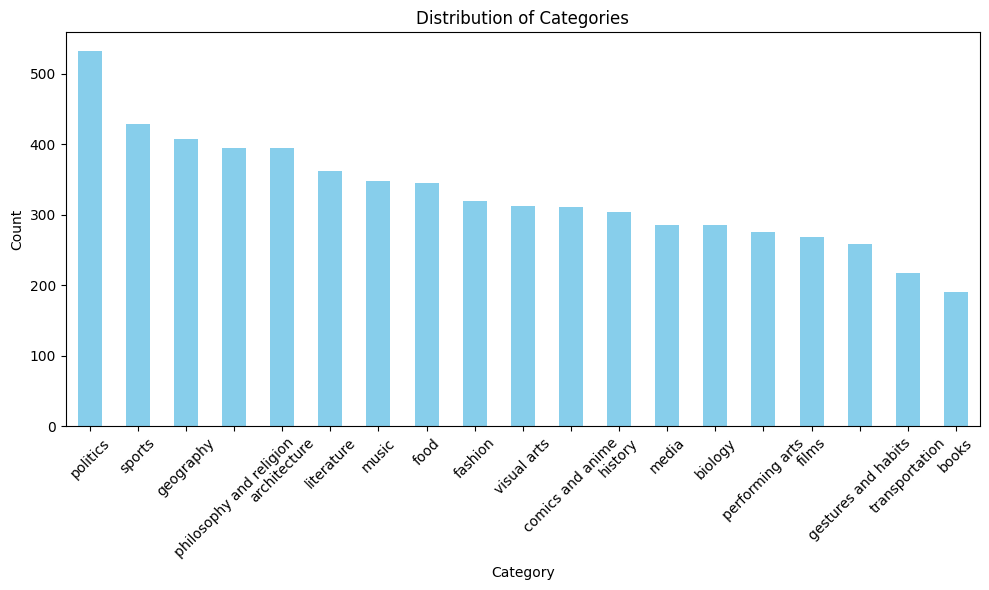

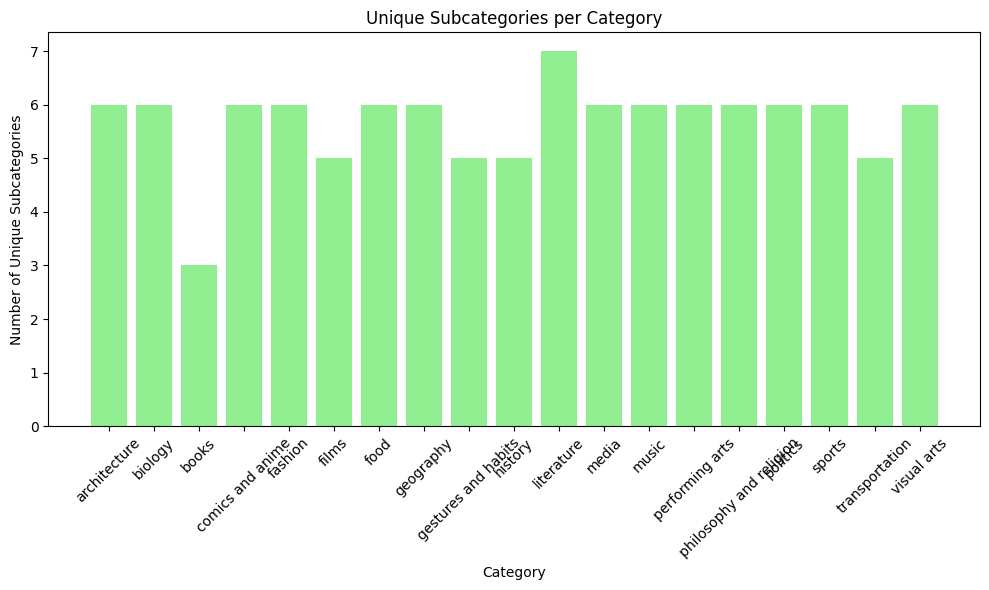

In [18]:
# 6) Additionally, print counts of entries for each category.
category_counts = df["category"].value_counts()
print("\nCounts for each Category:")
print(category_counts)

# And for each subcategory
subcategory_counts = df["subcategory"].value_counts()
print("\nCounts for each Subcategory:")
print(subcategory_counts)

# Visualize the distribution of the main categories.
category_counts = df["category"].value_counts()
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the number of unique subcategories for each main category.
subcat_counts = {cat: len(subcats) for cat, subcats in cat_subcat_dict.items()}
plt.figure(figsize=(10,6))
plt.bar(subcat_counts.keys(), subcat_counts.values(), color='lightgreen')
plt.xlabel("Category")
plt.ylabel("Number of Unique Subcategories")
plt.title("Unique Subcategories per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### 0.5.6: SAVE MODIFIED DATAFRAME (CSV)

In [19]:
df.to_csv("dataframe.csv", index=False)

#### 0.5: NEW VERSION (DATASET)

##### 0.5.0: SETUP STEP

In [9]:
# Login beforehand using huggingface-cli login if necessary.
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_data = ds["train"]
validation_data = ds["validation"]

# Create Pandas Dataframes just for better analysis.
train_df = train_data.to_pandas()
validation_df = validation_data.to_pandas()


In [10]:
train_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive


In [11]:
validation_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative


##### 0.5.1: NaN LABEL PRESENCE

In [12]:
df_train = check_nan_labels(train_df)
df_validation = check_nan_labels(validation_df)


=== NaN LABEL PRESENCE ===
Total missing values in the DataFrame: 0

Missing values by column:
item           0
name           0
description    0
type           0
category       0
subcategory    0
label          0
dtype: int64

Rows with missing values and the respective columns:
DataFrame shape before dropping rows with NaN: (6251, 7)
DataFrame shape after dropping rows with NaN: (6251, 7)
====== END =====

=== NaN LABEL PRESENCE ===
Total missing values in the DataFrame: 0

Missing values by column:
item           0
name           0
description    0
type           0
category       0
subcategory    0
label          0
dtype: int64

Rows with missing values and the respective columns:
DataFrame shape before dropping rows with NaN: (300, 7)
DataFrame shape after dropping rows with NaN: (300, 7)
====== END =====



##### 0.5.2: LABEL INCONSISTENCIES

In [13]:
train_df = check_labels_inconsistencies(train_df)
validation_df = check_labels_inconsistencies(validation_df)

=== LABEL INCONSISTENCIES PRESENCE ===
Original unique labels:
{'cultural agnostic', 'cultural exclusive', 'cultural representative'}
DataFrame shape before dropping rows with ambiguous labels: (6251, 7)
DataFrame shape after dropping rows with ambiguous labels: (6251, 7)

Unique labels after cleaning:
{'cultural agnostic', 'cultural exclusive', 'cultural representative'}
====== END =====

=== LABEL INCONSISTENCIES PRESENCE ===
Original unique labels:
{'cultural agnostic', 'cultural exclusive', 'cultural representative'}
DataFrame shape before dropping rows with ambiguous labels: (300, 7)
DataFrame shape after dropping rows with ambiguous labels: (300, 7)

Unique labels after cleaning:
{'cultural agnostic', 'cultural exclusive', 'cultural representative'}
====== END =====



##### 0.5.3: CLASS IMBALANCE


Label Counts:
label
cultural exclusive         2691
cultural agnostic          1872
cultural representative    1688
Name: count, dtype: int64


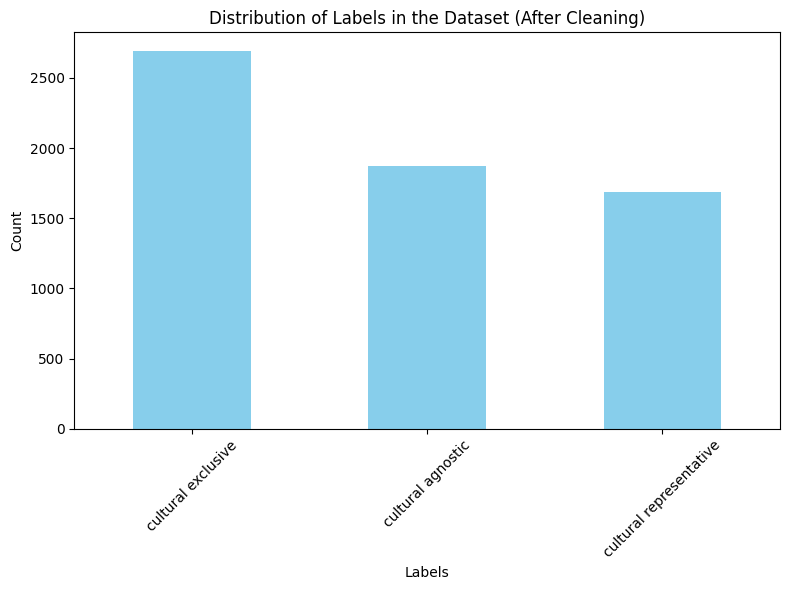


Label Counts:
label
cultural agnostic          117
cultural representative    107
cultural exclusive          76
Name: count, dtype: int64


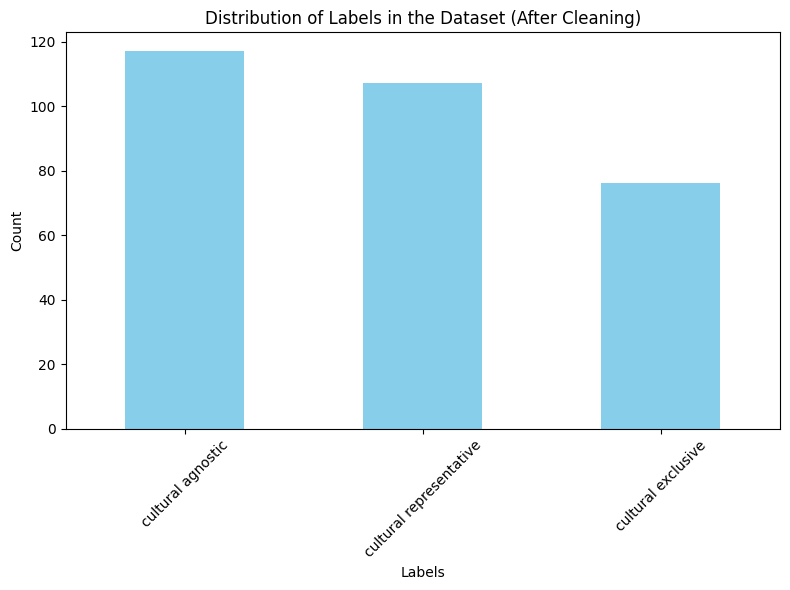

In [14]:
visualize_class_imbalance(train_df)
visualize_class_imbalance(validation_df)

##### 0.5.4: DUPLICATES DISCOVERY

In [15]:
check_duplicates(train_df)
check_duplicates(validation_df)

Cells that are not unique in column 'name':
['Alexandria' 'Breithorn' 'central government' 'Pirate Party' 'prefect'
 'Socialist Party']
Cells that are not unique in column 'name':
[]


##### 0.5.5: CLEANED DATASET INFORMATION


In [16]:
# 1) Display basic DF information.
print("=== Training DataFrame Info ===")
train_df.info()

print("=== Validation DataFrame Info ===")
validation_df.info()

=== Training DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251 entries, 0 to 6250
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item         6251 non-null   object
 1   name         6251 non-null   object
 2   description  6251 non-null   object
 3   type         6251 non-null   object
 4   category     6251 non-null   object
 5   subcategory  6251 non-null   object
 6   label        6251 non-null   object
dtypes: object(7)
memory usage: 342.0+ KB
=== Validation DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item         300 non-null    object
 1   name         300 non-null    object
 2   description  300 non-null    object
 3   type         300 non-null    object
 4   category     300 non-null    object
 5   subcategory  300 non-

In [17]:
# 2) Display DF Staistics.
print("\n=== Training DataFrame Statistics===")
print(train_df.describe())

print("\n=== Validation DataFrame Statistics===")
print(validation_df.describe())


=== Training DataFrame Statistics===
                                          item                name  \
count                                     6251                6251   
unique                                    6251                6245   
top     http://www.wikidata.org/entity/Q129298  central government   
freq                                         1                   2   

       description    type  category subcategory               label  
count         6251    6251      6251        6251                6251  
unique        5672       2        19         108                   3  
top     film genre  entity  politics  politician  cultural exclusive  
freq            32    3924       532          99                2691  

=== Validation DataFrame Statistics===
                                          item name  \
count                                      300  300   
unique                                     300  300   
top     http://www.wikidata.org/entity/Q615394  Yếm

In [18]:
# 3) Check for duplicate rows
duplicate_mask = train_df.duplicated()
num_duplicates = duplicate_mask.sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicate_mask])

# (DUPLICATES NOT PRESENT) !

Number of duplicate rows: 0


In [19]:
# 4) Checking that we have really 19 categories, and also checking the according subcategories.
unique_categories = train_df["category"].unique()
unique_subcategories = train_df["subcategory"].unique()

print("Unique Categories:")
print(unique_categories)
print(len(unique_categories))
print("\nUnique Subcategories:")
print(unique_subcategories)
print(len(unique_subcategories))



Unique Categories:
['films' 'music' 'comics and anime' 'architecture' 'geography' 'history'
 'books' 'media' 'philosophy and religion' 'food' 'visual arts' 'politics'
 'sports' 'literature' 'transportation' 'biology' 'gestures and habits'
 'performing arts' 'fashion']
19

Unique Subcategories:
['film' 'musical group' 'comics' 'building' 'city' 'historical event'
 'book' 'film studio' 'philosophical movement' 'media company' 'magazine'
 'television' 'animation technique' 'film festival' 'drink'
 'architectural structure' 'music festival' 'art gallery' 'painting'
 'animation studio' 'politician' 'sports team' 'religious leader' 'poet'
 'film producer' 'museum' 'automobile manufacturer' 'construction'
 'writer' 'tree' 'river' 'government agency' 'ritual' 'animated film'
 'recurring sporting event' 'sports club' 'policy' 'greeting' 'law'
 'musical profession' 'animal' 'music genre' 'organism' 'political party'
 'mode of transport' 'neighborhood' 'actor' 'publisher' 'designer'
 'geographic 

In [20]:
# 5) Category-SubCategories Dictionary construction.
cat_subcat_dict = train_df.groupby("category")["subcategory"].unique().to_dict()

print("Categories and their subcategories:")
for cat, subcats in cat_subcat_dict.items():
    print(f"Category: {cat} -> Subcategories: {list(subcats)} (Count: {len(subcats)})")

Categories and their subcategories:
Category: architecture -> Subcategories: ['building', 'architectural structure', 'construction', 'building material', 'architect', 'architectural style'] (Count: 6)
Category: biology -> Subcategories: ['tree', 'animal', 'organism', 'biologist', 'plant', 'fish'] (Count: 6)
Category: books -> Subcategories: ['book', 'non-fiction writer', 'bookstore'] (Count: 3)
Category: comics and anime -> Subcategories: ['comics', 'animation technique', 'animation studio', 'animated film', 'comics artist', 'manga'] (Count: 6)
Category: fashion -> Subcategories: ['designer', 'textile', 'traditional costume', 'clothing', 'model', 'fashion trend'] (Count: 6)
Category: films -> Subcategories: ['film', 'film festival', 'film producer', 'film director', 'film genre'] (Count: 5)
Category: food -> Subcategories: ['drink', 'dish', 'ingredient', 'food', 'cooking technique', 'cook'] (Count: 6)
Category: geography -> Subcategories: ['city', 'river', 'neighborhood', 'geographic l


Counts for each Category:
category
politics                   532
sports                     429
geography                  411
architecture               396
philosophy and religion    395
literature                 363
music                      348
food                       346
fashion                    319
visual arts                313
comics and anime           312
history                    304
biology                    286
media                      285
performing arts            275
films                      269
gestures and habits        259
transportation             217
books                      192
Name: count, dtype: int64

Counts for each Subcategory:
subcategory
politician           99
film                 95
law                  95
sport                95
ritual               94
                     ..
environment           5
cooking technique     4
fashion trend         4
writing style         4
body language         1
Name: count, Length: 108, dtype: int64


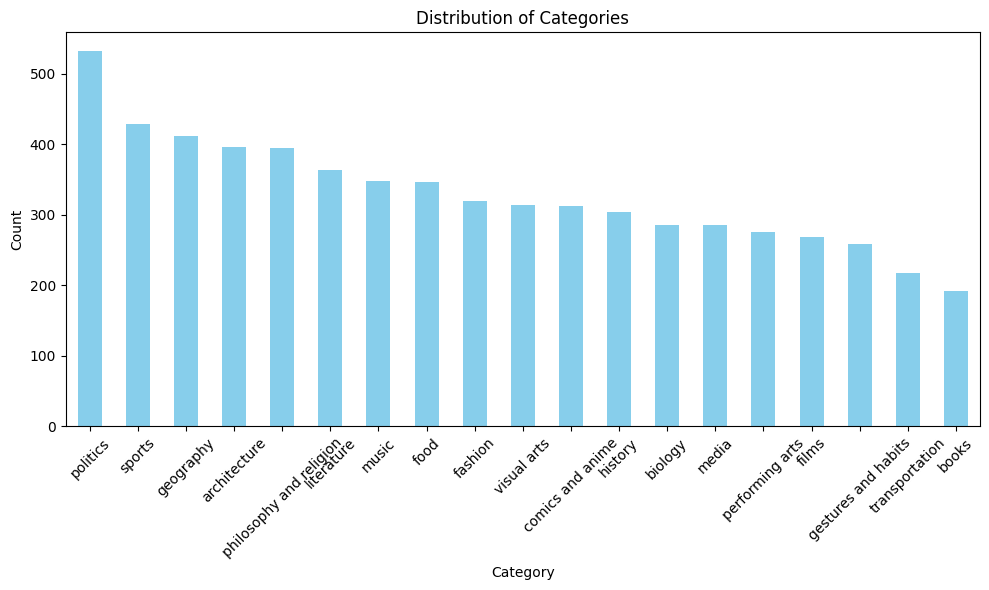

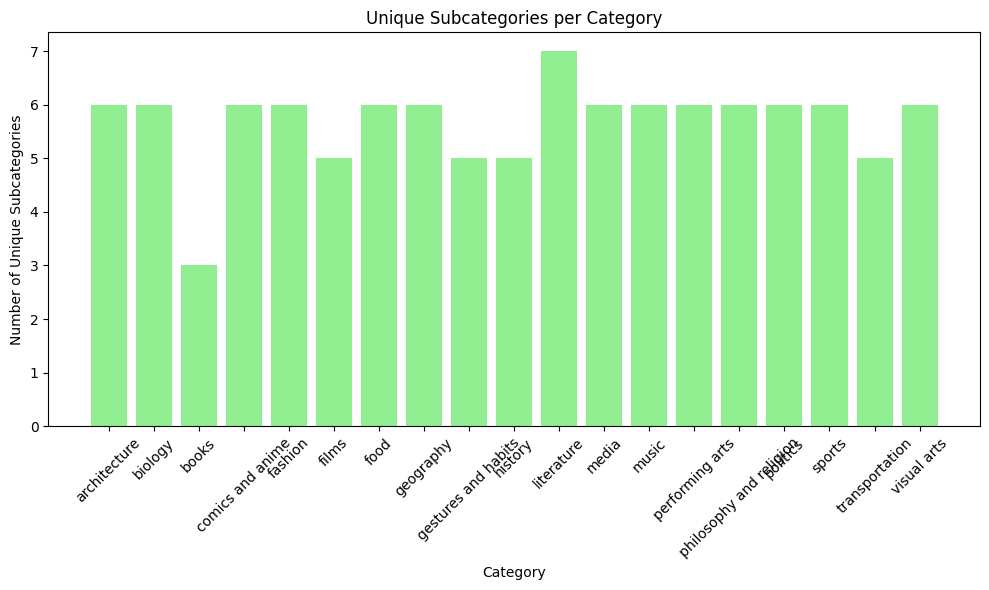

In [21]:
# 6) Additionally, print counts of entries for each category.
category_counts = train_df["category"].value_counts()
print("\nCounts for each Category:")
print(category_counts)

# And for each subcategory
subcategory_counts = train_df["subcategory"].value_counts()
print("\nCounts for each Subcategory:")
print(subcategory_counts)

# Visualize the distribution of the main categories.
category_counts = train_df["category"].value_counts()
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the number of unique subcategories for each main category.
subcat_counts = {cat: len(subcats) for cat, subcats in cat_subcat_dict.items()}
plt.figure(figsize=(10,6))
plt.bar(subcat_counts.keys(), subcat_counts.values(), color='lightgreen')
plt.xlabel("Category")
plt.ylabel("Number of Unique Subcategories")
plt.title("Unique Subcategories per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2: GRAPH CONSTRUCTION

In [24]:
import itertools
import networkx as nx
import pandas as pd
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.utils import from_networkx

# — assume train_df & validation_df are already loaded, with columns:
#   ['item','name','description','type','category','subcategory','label']

# 1) tag splits and concat
train_df = train_df.copy()
val_df   = validation_df.copy()

train_df['split'] = 'train'
val_df  ['split'] = 'val'

df = pd.concat([train_df, val_df], ignore_index=True)

# 2) add explicit mask columns
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'

n = len(df)

# 3) build a NetworkX graph
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 4) clique‐connect by category & subcategory
for attr in ['category','subcategory']:
    for _, idxs in df.groupby(attr).groups.items():
        for u, v in itertools.combinations(idxs, 2):
            G.add_edge(u, v)

# 5) TF–IDF features on "name + description"
texts = (df['name'] + " " + df['description']).tolist()
tfidf = TfidfVectorizer(max_features=1_000)
X = tfidf.fit_transform(texts).toarray()   # shape [n,1000]

# 6) label‐map
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values  # [n,]

# 7) stash x, y, and masks on nodes
for i in range(n):
    G.nodes[i]['x']          = X[i]
    G.nodes[i]['y']          = int(Y[i])
    G.nodes[i]['train_mask'] = G.nodes[i]['train_mask']
    G.nodes[i]['val_mask']   = G.nodes[i]['val_mask']

# 8) convert to torch_geometric.Data
data = from_networkx(G)

# fix dtypes / names to PyG conventions
data.x           = data.x.float()          # [n,1000]
data.y           = data.y.long()           # [n]
data.train_mask  = data.train_mask.bool()  # [n]
data.val_mask    = data.val_mask.bool()    # [n]

print(data)
# Data(x=[N,1000], edge_index=[2, E], y=[N], train_mask=[N], val_mask=[N])


Data(x=[6551, 1000], edge_index=[2, 2369932], y=[6551], category=[6551], subcategory=[6551], train_mask=[6551], val_mask=[6551])


/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data_dict[key] = torch.as_tensor(value)


In [34]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.metrics import precision_score, recall_score, f1_score

# ─── Reproducibility / Determinism ─────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

# ─── Device ────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Assume `data` is already built and contains:
#       data.x, data.edge_index, data.y, data.train_mask, data.val_mask
data = data.to(device)

# ─── Compute class weights for imbalanced cross‑entropy ────────────────────────
train_y      = data.y[data.train_mask]
class_counts = torch.bincount(train_y)
class_weights = 1.0 / (class_counts.float() + 1e-6)
class_weights = class_weights / class_weights.sum() * class_counts.numel()
class_weights = class_weights.to(device)

# ─── Model: 4‑layer GCN with residual + BatchNorm ───────────────────────────────
class DeepGCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 num_layers=4, dropout=0.5):
        super().__init__()
        assert num_layers >= 2
        self.num_layers = num_layers
        self.dropout    = torch.nn.Dropout(dropout)

        # input layer
        self.convs = torch.nn.ModuleList()
        self.bns   = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_dim, hid_dim))
        self.bns.append(BatchNorm(hid_dim))

        # hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hid_dim, hid_dim))
            self.bns.append(BatchNorm(hid_dim))

        # output layer
        self.convs.append(GCNConv(hid_dim, out_dim))
        # skip projector
        self.res_lin = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        x0 = x
        # first conv
        x = self.convs[0](x, edge_index)
        x = self.bns[0](x).relu()
        x = self.dropout(x)
        # middle convs
        for i in range(1, self.num_layers - 1):
            h = self.convs[i](x, edge_index)
            x = self.bns[i](h + x).relu()
            x = self.dropout(x)
        # final conv + skip
        x = self.convs[-1](x, edge_index)
        return x + self.res_lin(x0)

model = DeepGCN(in_dim = data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                num_layers=4,
                dropout=0.5).to(device)

# ─── Optimizer & Scheduler ─────────────────────────────────────────────────────
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=50,
                                            gamma=0.5)

# ─── Early Stopping Setup ──────────────────────────────────────────────────────
patience       = 200
best_val_loss  = float('inf')
epochs_no_imp  = 0
max_epochs     = 2000
best_state     = None

# ─── Training Loop with Early Stopping & Periodic Prints ───────────────────────
for epoch in range(1, max_epochs+1):
    # — Train —
    model.train()
    optimizer.zero_grad()
    out   = model(data.x, data.edge_index)
    loss  = F.cross_entropy(out[data.train_mask],
                            data.y[data.train_mask],
                            weight=class_weights)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # — Validate —
    model.eval()
    with torch.no_grad():
        logits     = model(data.x, data.edge_index)
        val_logits = logits[data.val_mask]
        val_labels = data.y[data.val_mask]
        val_loss   = F.cross_entropy(val_logits, val_labels).item()

        preds      = val_logits.argmax(dim=1)
        acc        = (preds == val_labels).float().mean().item()
        y_true     = val_labels.cpu().numpy()
        y_pred     = preds.cpu().numpy()
        prec       = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec        = recall_score(   y_true, y_pred, average='macro', zero_division=0)
        f1         = f1_score(       y_true, y_pred, average='macro', zero_division=0)
        ppl        = torch.exp(torch.tensor(val_loss)).item()

    # — Early Stopping Check —
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_imp = 0
        best_state   = model.state_dict()
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # — Periodic Logging every 10 epochs —
    if epoch % 10 == 0:
        print(f"[Epoch {epoch:03d}] "
              f"Train Loss: {loss:.4f}  "
              f"Val Loss: {val_loss:.4f}  "
              f"Val Acc: {acc:.4f}  "
              f"Prec: {prec:.4f}  "
              f"Rec: {rec:.4f}  "
              f"F1: {f1:.4f}  "
              f"PPL: {ppl:.2f}")

# ─── Load Best Model & Final Evaluation ────────────────────────────────────────
model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    logits     = model(data.x, data.edge_index)
    val_logits = logits[data.val_mask]
    val_labels = data.y[data.val_mask]

    preds      = val_logits.argmax(dim=1)
    acc        = (preds == val_labels).float().mean().item()
    y_true     = val_labels.cpu().numpy()
    y_pred     = preds.cpu().numpy()
    prec       = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec        = recall_score(   y_true, y_pred, average='macro', zero_division=0)
    f1         = f1_score(       y_true, y_pred, average='macro', zero_division=0)
    perplexity = torch.exp(torch.tensor(best_val_loss)).item()

print(f"\nBest Val Loss: {best_val_loss:.4f}")
print(f"Final Val Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, PPL: {perplexity:.2f}")


[Epoch 010] Train Loss: 0.9901  Val Loss: 1.0901  Val Acc: 0.4433  Prec: 0.5107  Rec: 0.4018  F1: 0.3360  PPL: 2.97
[Epoch 020] Train Loss: 0.9742  Val Loss: 1.0863  Val Acc: 0.5033  Prec: 0.4984  Rec: 0.5150  F1: 0.4062  PPL: 2.96
[Epoch 030] Train Loss: 0.9640  Val Loss: 1.0798  Val Acc: 0.5200  Prec: 0.5946  Rec: 0.5329  F1: 0.4292  PPL: 2.94
[Epoch 040] Train Loss: 0.9559  Val Loss: 1.0721  Val Acc: 0.5533  Prec: 0.6369  Rec: 0.5678  F1: 0.4827  PPL: 2.92
[Epoch 050] Train Loss: 0.9481  Val Loss: 1.0640  Val Acc: 0.5667  Prec: 0.6338  Rec: 0.5797  F1: 0.5000  PPL: 2.90
[Epoch 060] Train Loss: 0.9418  Val Loss: 1.0586  Val Acc: 0.5633  Prec: 0.5843  Rec: 0.5698  F1: 0.5181  PPL: 2.88
[Epoch 070] Train Loss: 0.9375  Val Loss: 1.0494  Val Acc: 0.5467  Prec: 0.5303  Rec: 0.5452  F1: 0.5262  PPL: 2.86
[Epoch 080] Train Loss: 0.9338  Val Loss: 1.0409  Val Acc: 0.5100  Prec: 0.5089  Rec: 0.5063  F1: 0.5042  PPL: 2.83
[Epoch 090] Train Loss: 0.9293  Val Loss: 1.0374  Val Acc: 0.4700  Prec:

In [35]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.metrics import precision_score, recall_score, f1_score

# ─── 1) Reproducibility ─────────────────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

# ─── 2) Device & Data ──────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data   = data.to(device)   # assume `data` already exists with x, edge_index, y, train_mask, val_mask

# ─── 3) Class weights ──────────────────────────────────────────────────────────
train_y      = data.y[data.train_mask]
class_counts = torch.bincount(train_y)
class_weights = 1.0 / (class_counts.float() + 1e-6)
class_weights = class_weights / class_weights.sum() * class_counts.numel()
class_weights = class_weights.to(device)

# ─── 4) Model: 2‑layer GAT ──────────────────────────────────────────────────────
class GATNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 heads=4, dropout=0.5):
        super().__init__()
        # first GAT layer: in_dim → hid_dim with multi‑head attention
        self.conv1   = GATConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        # second GAT layer: hid_dim*heads → out_dim, single head, no concat
        self.conv2   = GATConv(hid_dim*heads, out_dim,
                               heads=1, concat=False, dropout=dropout)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index):
        # layer1 + ELU + dropout
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        # layer2 + dropout
        x = self.conv2(x, edge_index)
        return self.dropout(x)

model = GATNet(in_dim = data.x.size(1),
               hid_dim=32,
               out_dim = 3,
               heads   = 4,
               dropout = 0.5).to(device)

# ─── 5) Optimizer & Scheduler ─────────────────────────────────────────────────
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=50,
                                            gamma=0.5)

# ─── 6) Early Stopping Setup ───────────────────────────────────────────────────
patience       = 200
best_val_loss  = float('inf')
epochs_no_imp  = 0
max_epochs     = 2000
best_state     = None

# ─── 7) Training Loop with Early Stopping & Logging ────────────────────────────
for epoch in range(1, max_epochs+1):
    # — train step —
    model.train()
    optimizer.zero_grad()
    out   = model(data.x, data.edge_index)
    loss  = F.cross_entropy(out[data.train_mask],
                            data.y[data.train_mask],
                            weight=class_weights)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # — validation step —
    model.eval()
    with torch.no_grad():
        logits     = model(data.x, data.edge_index)
        val_logits = logits[data.val_mask]
        val_labels = data.y[data.val_mask]

        val_loss = F.cross_entropy(val_logits, val_labels).item()

        preds = val_logits.argmax(dim=1)
        acc   = (preds == val_labels).float().mean().item()

        y_true = val_labels.cpu().numpy()
        y_pred = preds.cpu().numpy()
        prec   = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec    = recall_score(   y_true, y_pred, average='macro', zero_division=0)
        f1     = f1_score(       y_true, y_pred, average='macro', zero_division=0)
        ppl    = torch.exp(torch.tensor(val_loss)).item()

    # — early stopping check —
    if val_loss + 1e-4 < best_val_loss:
        best_val_loss = val_loss
        epochs_no_imp = 0
        best_state   = model.state_dict()
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # — periodic logging every 10 epochs —
    if epoch % 10 == 0:
        print(f"[Epoch {epoch:03d}] "
              f"Train Loss: {loss:.4f}  "
              f"Val Loss: {val_loss:.4f}  "
              f"Val Acc: {acc:.4f}  "
              f"Prec: {prec:.4f}  "
              f"Rec: {rec:.4f}  "
              f"F1: {f1:.4f}  "
              f"PPL: {ppl:.2f}")

# ─── 8) Load Best Model & Final Metrics ────────────────────────────────────────
model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    logits     = model(data.x, data.edge_index)
    val_logits = logits[data.val_mask]
    val_labels = data.y[data.val_mask]

    preds = val_logits.argmax(dim=1)
    acc   = (preds == val_labels).float().mean().item()
    y_true = val_labels.cpu().numpy()
    y_pred = preds.cpu().numpy()
    prec   = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec    = recall_score(   y_true, y_pred, average='macro', zero_division=0)
    f1     = f1_score(       y_true, y_pred, average='macro', zero_division=0)
    ppl    = torch.exp(torch.tensor(best_val_loss)).item()

print(f"\nBest Val Loss: {best_val_loss:.4f}")
print(f"Final Val Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, PPL: {ppl:.2f}")


[Epoch 010] Train Loss: 1.0738  Val Loss: 1.0784  Val Acc: 0.4233  Prec: 0.4324  Rec: 0.4172  F1: 0.4138  PPL: 2.94
[Epoch 020] Train Loss: 1.0526  Val Loss: 1.0652  Val Acc: 0.4500  Prec: 0.4518  Rec: 0.4409  F1: 0.4335  PPL: 2.90
[Epoch 030] Train Loss: 1.0400  Val Loss: 1.0584  Val Acc: 0.4500  Prec: 0.4518  Rec: 0.4409  F1: 0.4335  PPL: 2.88
[Epoch 040] Train Loss: 1.0336  Val Loss: 1.0578  Val Acc: 0.4500  Prec: 0.4518  Rec: 0.4409  F1: 0.4335  PPL: 2.88
[Epoch 050] Train Loss: 1.0331  Val Loss: 1.0570  Val Acc: 0.4500  Prec: 0.4518  Rec: 0.4409  F1: 0.4335  PPL: 2.88
[Epoch 060] Train Loss: 1.0271  Val Loss: 1.0601  Val Acc: 0.4500  Prec: 0.4518  Rec: 0.4409  F1: 0.4335  PPL: 2.89
[Epoch 070] Train Loss: 1.0315  Val Loss: 1.0588  Val Acc: 0.4500  Prec: 0.4518  Rec: 0.4409  F1: 0.4335  PPL: 2.88
[Epoch 080] Train Loss: 1.0226  Val Loss: 1.0594  Val Acc: 0.4500  Prec: 0.4518  Rec: 0.4409  F1: 0.4335  PPL: 2.88
[Epoch 090] Train Loss: 1.0328  Val Loss: 1.0602  Val Acc: 0.4500  Prec:

In [37]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, BatchNorm
from sklearn.metrics import precision_score, recall_score, f1_score

# ─── 1) Reproducibility ─────────────────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
os.environ["PYTHONHASHSEED"]       = str(seed)

# ─── 2) Device & Data ──────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data   = data.to(device)   # assume `data` already has x, edge_index, y, train_mask, val_mask

# ─── 3) Class weights for imbalanced CE ────────────────────────────────────────
train_y      = data.y[data.train_mask]
class_counts = torch.bincount(train_y)
class_weights = 1.0 / (class_counts.float() + 1e-6)
class_weights = class_weights / class_weights.sum() * class_counts.numel()
class_weights = class_weights.to(device)

# ─── 4) Model: 2‑layer GraphSAGE with BatchNorm & Dropout ──────────────────────
class GraphSAGENet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1   = SAGEConv(in_dim, hid_dim)
        self.bn1     = BatchNorm(hid_dim)
        self.conv2   = SAGEConv(hid_dim, out_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return self.dropout(x)

model = GraphSAGENet(in_dim = data.x.size(1),
                     hid_dim=64,
                     out_dim = 3,
                     dropout = 0.5).to(device)

# ─── 5) Optimizer & Scheduler ─────────────────────────────────────────────────
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=50,
                                            gamma=0.5)

# ─── 6) Early Stopping Setup ───────────────────────────────────────────────────
patience       = 200
best_val_loss  = float('inf')
epochs_no_imp  = 0
max_epochs     = 2000
best_state     = None

# ─── 7) Training Loop with Early Stopping & Logging ────────────────────────────
for epoch in range(1, max_epochs+1):
    # — train step —
    model.train()
    optimizer.zero_grad()
    out   = model(data.x, data.edge_index)
    loss  = F.cross_entropy(out[data.train_mask],
                            data.y[data.train_mask],
                            weight=class_weights)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # — validation step —
    model.eval()
    with torch.no_grad():
        logits     = model(data.x, data.edge_index)
        val_logits = logits[data.val_mask]
        val_labels = data.y[data.val_mask]

        val_loss = F.cross_entropy(val_logits, val_labels).item()

        preds = val_logits.argmax(dim=1)
        acc   = (preds == val_labels).float().mean().item()

        y_true = val_labels.cpu().numpy()
        y_pred = preds.cpu().numpy()
        prec   = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec    = recall_score(   y_true, y_pred, average='macro', zero_division=0)
        f1     = f1_score(       y_true, y_pred, average='macro', zero_division=0)
        ppl    = torch.exp(torch.tensor(val_loss)).item()

    # — early stopping check —
    if val_loss + 1e-4 < best_val_loss:
        best_val_loss = val_loss
        epochs_no_imp = 0
        best_state   = model.state_dict()
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # — periodic logging every 10 epochs —
    if epoch % 10 == 0:
        print(f"[Epoch {epoch:03d}] "
              f"Train Loss: {loss:.4f}  "
              f"Val Loss: {val_loss:.4f}  "
              f"Val Acc: {acc:.4f}  "
              f"Prec: {prec:.4f}  "
              f"Rec: {rec:.4f}  "
              f"F1: {f1:.4f}  "
              f"PPL: {ppl:.2f}")

# ─── 8) Load Best Model & Final Metrics ────────────────────────────────────────
model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    logits     = model(data.x, data.edge_index)
    val_logits = logits[data.val_mask]
    val_labels = data.y[data.val_mask]

    preds = val_logits.argmax(dim=1)
    acc   = (preds == val_labels).float().mean().item()
    y_true = val_labels.cpu().numpy()
    y_pred = preds.cpu().numpy()
    prec   = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec    = recall_score(   y_true, y_pred, average='macro', zero_division=0)
    f1     = f1_score(       y_true, y_pred, average='macro', zero_division=0)
    ppl    = torch.exp(torch.tensor(best_val_loss)).item()

print(f"\nBest Val Loss: {best_val_loss:.4f}")
print(f"Final Val Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, PPL: {ppl:.2f}")


[Epoch 010] Train Loss: 0.9020  Val Loss: 1.0831  Val Acc: 0.3567  Prec: 0.1189  Rec: 0.3333  F1: 0.1753  PPL: 2.95
[Epoch 020] Train Loss: 0.7928  Val Loss: 1.0612  Val Acc: 0.4700  Prec: 0.7184  Rec: 0.4394  F1: 0.3686  PPL: 2.89
[Epoch 030] Train Loss: 0.7393  Val Loss: 1.0260  Val Acc: 0.6033  Prec: 0.6487  Rec: 0.5778  F1: 0.5770  PPL: 2.79
[Epoch 040] Train Loss: 0.7049  Val Loss: 0.9685  Val Acc: 0.6367  Prec: 0.6439  Rec: 0.6164  F1: 0.6217  PPL: 2.63
[Epoch 050] Train Loss: 0.6712  Val Loss: 0.8970  Val Acc: 0.6400  Prec: 0.6238  Rec: 0.6212  F1: 0.6223  PPL: 2.45
[Epoch 060] Train Loss: 0.6587  Val Loss: 0.8321  Val Acc: 0.6367  Prec: 0.6183  Rec: 0.6211  F1: 0.6193  PPL: 2.30
[Epoch 070] Train Loss: 0.6462  Val Loss: 0.7949  Val Acc: 0.6267  Prec: 0.6088  Rec: 0.6120  F1: 0.6097  PPL: 2.21
[Epoch 080] Train Loss: 0.6331  Val Loss: 0.7898  Val Acc: 0.6233  Prec: 0.6064  Rec: 0.6092  F1: 0.6068  PPL: 2.20
[Epoch 090] Train Loss: 0.6196  Val Loss: 0.8000  Val Acc: 0.6233  Prec:

In [39]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv
from sklearn.metrics import precision_score, recall_score, f1_score

# ─── 1) Reproducibility ─────────────────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
os.environ["PYTHONHASHSEED"]       = str(seed)

# ─── 2) Device & Data ──────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data   = data.to(device)   # assume `data` has x, edge_index, y, train_mask, val_mask

# ─── 3) Class weights for imbalanced CE ────────────────────────────────────────
train_y      = data.y[data.train_mask]
class_counts = torch.bincount(train_y)
class_weights = 1.0 / (class_counts.float() + 1e-6)
class_weights = class_weights / class_weights.sum() * class_counts.numel()
class_weights = class_weights.to(device)

# ─── 4) Model: 3‑layer GIN for node classification ──────────────────────────────
class GINNodeClassifier(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        # MLP for each GINConv
        self.conv1 = GINConv(Sequential(
            Linear(in_dim, hid_dim), BatchNorm1d(hid_dim), ReLU(),
            Linear(hid_dim, hid_dim), ReLU()))
        self.conv2 = GINConv(Sequential(
            Linear(hid_dim, hid_dim), BatchNorm1d(hid_dim), ReLU(),
            Linear(hid_dim, hid_dim), ReLU()))
        self.conv3 = GINConv(Sequential(
            Linear(hid_dim, hid_dim), BatchNorm1d(hid_dim), ReLU(),
            Linear(hid_dim, hid_dim), ReLU()))
        self.dropout = Dropout(dropout)
        self.lin = Linear(hid_dim, out_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        logits = self.lin(x)                 # shape [num_nodes, out_dim]
        return logits

model = GINNodeClassifier(
    in_dim  = data.x.size(1),
    hid_dim = 64,
    out_dim = 3,
    dropout = 0.5
).to(device)

# ─── 5) Optimizer & Scheduler ─────────────────────────────────────────────────
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=50,
                                            gamma=0.5)

# ─── 6) Early Stopping Setup ───────────────────────────────────────────────────
patience       = 200
best_val_loss  = float('inf')
epochs_no_imp  = 0
max_epochs     = 2000
best_state     = None

# ─── 7) Training Loop with Early Stopping & Logging ───────────────────────────
for epoch in range(1, max_epochs+1):
    # — train —
    model.train()
    optimizer.zero_grad()
    logits     = model(data.x, data.edge_index)
    train_loss = F.cross_entropy(
        logits[data.train_mask],
        data.y[data.train_mask],
        weight=class_weights
    )
    train_loss.backward()
    optimizer.step()
    scheduler.step()

    # — validate —
    model.eval()
    with torch.no_grad():
        val_logits = model(data.x, data.edge_index)[data.val_mask]
        val_labels = data.y[data.val_mask]
        val_loss   = F.cross_entropy(val_logits, val_labels).item()

        preds = val_logits.argmax(dim=1)
        acc   = (preds == val_labels).float().mean().item()
        y_t   = val_labels.cpu().numpy()
        y_p   = preds.cpu().numpy()
        prec  = precision_score(y_t, y_p, average='macro', zero_division=0)
        rec   = recall_score(   y_t, y_p, average='macro', zero_division=0)
        f1    = f1_score(       y_t, y_p, average='macro', zero_division=0)
        ppl   = torch.exp(torch.tensor(val_loss)).item()

    # — early stopping check —
    if val_loss + 1e-4 < best_val_loss:
        best_val_loss = val_loss
        epochs_no_imp = 0
        best_state   = model.state_dict()
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # — periodic logging every 10 epochs —
    if epoch % 10 == 0:
        print(f"[Epoch {epoch:03d}] "
              f"Train Loss: {train_loss:.4f}  "
              f"Val Loss:   {val_loss:.4f}  "
              f"Val Acc:    {acc:.4f}  "
              f"Prec:       {prec:.4f}  "
              f"Rec:        {rec:.4f}  "
              f"F1:         {f1:.4f}  "
              f"PPL:        {ppl:.2f}")

# ─── 8) Load Best Model & Final Metrics ────────────────────────────────────────
model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    final_logits = model(data.x, data.edge_index)[data.val_mask]
    final_labels = data.y[data.val_mask]
    preds        = final_logits.argmax(dim=1)
    acc          = (preds == final_labels).float().mean().item()
    y_t          = final_labels.cpu().numpy()
    y_p          = preds.cpu().numpy()
    prec         = precision_score(y_t, y_p, average='macro', zero_division=0)
    rec          = recall_score(   y_t, y_p, average='macro', zero_division=0)
    f1           = f1_score(       y_t, y_p, average='macro', zero_division=0)
    ppl          = torch.exp(torch.tensor(best_val_loss)).item()

print(f"\nBest Val Loss: {best_val_loss:.4f}")
print(f"Final Val Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, PPL: {ppl:.2f}")


[Epoch 010] Train Loss: 1.0103  Val Loss:   1.1155  Val Acc:    0.4533  Prec:       0.4773  Rec:        0.4790  F1:         0.4417  PPL:        3.05
[Epoch 020] Train Loss: 0.9989  Val Loss:   1.0767  Val Acc:    0.4400  Prec:       0.4499  Rec:        0.4337  F1:         0.4185  PPL:        2.93
[Epoch 030] Train Loss: 0.9939  Val Loss:   1.0844  Val Acc:    0.4500  Prec:       0.4518  Rec:        0.4409  F1:         0.4335  PPL:        2.96
[Epoch 040] Train Loss: 0.9965  Val Loss:   1.0871  Val Acc:    0.4500  Prec:       0.4518  Rec:        0.4409  F1:         0.4335  PPL:        2.97
[Epoch 050] Train Loss: 0.9891  Val Loss:   1.0903  Val Acc:    0.4500  Prec:       0.4518  Rec:        0.4409  F1:         0.4335  PPL:        2.98
[Epoch 060] Train Loss: 0.9919  Val Loss:   1.0902  Val Acc:    0.4500  Prec:       0.4518  Rec:        0.4409  F1:         0.4335  PPL:        2.97
[Epoch 070] Train Loss: 0.9889  Val Loss:   1.0920  Val Acc:    0.4500  Prec:       0.4518  Rec:        0.

### 2.OLD

--------------------------
**HETEROUGENEOUS GRAPHS**

For this task, we will build a set of **Heterogeneous Graphs**. This is a graph in which **nodes and/or edges belong to different types**. In other words, it is a **multi-relational graph** where each node may have its own feature space and each edge represents a specific type of relationship.

In our implementation, the **main entity** (for example, a food item like "Pizza") is represented as a **primary node** (of type "item"). **Additional nodes** are created for **various attributes** (e.g., categories, instance_of, subclass_of, creator, location, genre) using the enriched data from Wikidata and Wikipedia. Each attribute node is connected to the main item node by an edge that denotes the nature of the relationship (e.g., "has_category" for categories).

--------------------------
**CONTEXTUAL EMBEDDINGS**

To generate meaningful **feature vectors**, we employ a **Sentence Transformer** (using the ***all-mpnet-base-v2 model***) to compute Contextual Embeddings. We enhance the representation of the main node by unifying the label and the Wikipedia summary into one text. This is then encoded into a dense vector that captures fine semantic nuances. The attribute nodes are similarly embedded using their respective textual information.

*WHY SENTENCE TRASNFORMER: all-mpnet-base-v2 model*

We choose **all-mpnet-base-v2 model** because it strikes an excellent balance between efficiency and the quality of contextual embeddings. Indeed:

- **BERT** adopts masked language modeling (MLM) for pre-training and is one of the most successful pre-training models. However BERT neglects dependency among predicted tokens. *BERT* and *RoBERTa* at their time set a new state-of-the-art performance (particularly on sentence-pair regression tasks like semantic textual similarity (STS)), but they however require that both sentences are fed into the network, causing a **massive computational overhead**. The construction of BERT makes it unsuitable for semantic similarity search. **Sentence-BERT (SBERT)** is a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT.
- **XLNet** introduces permuted language modeling (PLM) for pre-training to address this problem. However, XLNet does not leverage the full position information of a sentence and thus suffers from position discrepancy between pre-training and fine-tuning.
- **MPNet** inherits the advantages of BERT and XLNet and avoids their limitations. MPNet leverages the dependency among predicted tokens through permuted language modeling (vs. MLM in BERT), and takes auxiliary position information as input to make the model see a full sentence and thus reducing the position discrepancy (vs. PLM in XLNet). Also as concerns avg performances in terms of speed, we also have that this is fast w.r.t. the others.

For more info about model performances: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

***(REFERENCES)***
- *BERT*: https://arxiv.org/abs/1810.04805
- *RoBERTa*: https://arxiv.org/abs/1907.11692
- *XLNet*: https://arxiv.org/abs/1906.08237
- *Sentence-BERT*: https://arxiv.org/abs/1908.10084
- *MPNet*: https://arxiv.org/abs/2004.09297



--------------------------
**EDGES WEIGHTING: COSINE SIMILARITY**

**Edges** between the main node and each attribute node are **weighted** by computing the **Cosine Similarity** between their **embeddings**. We decide to apply this with the aim to have them to be **Semantic Similarity Scores** that help to reflect the **main entity & its attributes relationship strength**.


### 3: HETEROPHILY INDEX

### 4: SHEAF NEURAL NETWORK